In [1]:
import numpy as np
from scipy.optimize import root
import logging
import perceval as pcvl
from perceval.algorithm import Sampler
from perceval.components import PS, BS
import sys

from utils import svd_decomposition, print_circuit_structure
from clements import decompose_clements

logging.basicConfig(
    stream=sys.stdout,      # Direct logs to stdout
    level=logging.DEBUG
)

In [2]:
# 1. Define the system of equations
# x is a list of your 16 unknowns [x0, x1, ... x15]
def equations(x):
    # Unpack variables for clarity if needed, or index directly
    # Example: let's say variables 0-3 correspond to equation 1's a,b,c,d
    
    # We create an array to store the "error" for each of the 16 equations
    # The solver tries to make these equal to 0
    
    # Placeholder for your 16 constants (k)
    #k = np.zeros(16)
    #H = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])
    A = np.array([
        [ 1.0,  0.0,  0.0,  0.0],
        [ 0.0,  1.0,  0.0,  0.0],
        [ 0.0,  0.0,  0.0,  1.0],
        [ 0.0,  0.0,  1.0,  0.0]
    ])
    
    #k = np.identity(4).flatten()
    k = A.flatten()
    #print(k)
    
    eqs = []
    
    # --- ENTER YOUR 16 EQUATIONS BELOW ---
    # format: (expression) - constant
    
    # Example Equation 1: x0*x3 + x1*x2 = k0
    eqs.append( (x[0] * x[10] + x[2] * x[8]) - k[0] )
    eqs.append( (x[0] * x[14] + x[2] * x[12]) - k[4] )
    eqs.append( (x[4] * x[10] + x[6] * x[8]) - k[8] )
    eqs.append( (x[4] * x[14] + x[6] * x[12]) - k[12] )

    eqs.append( (x[0] * x[11] + x[3] * x[8]) - k[1] )
    eqs.append( (x[0] * x[15] + x[3] * x[12]) - k[5] )
    eqs.append( (x[4] * x[11] + x[7] * x[8]) - k[9] )
    eqs.append( (x[4] * x[15] + x[7] * x[12]) - k[13] )

    eqs.append( (x[1] * x[10] + x[2] * x[9]) - k[2] )
    eqs.append( (x[1] * x[14] + x[2] * x[13]) - k[6] )
    eqs.append( (x[5] * x[10] + x[6] * x[9]) - k[10] )
    eqs.append( (x[5] * x[14] + x[6] * x[13]) - k[14] )

    eqs.append( (x[1] * x[11] + x[3] * x[9]) - k[3] )
    eqs.append( (x[1] * x[15] + x[3] * x[13]) - k[7] )
    eqs.append( (x[5] * x[11] + x[7] * x[9]) - k[11] )
    eqs.append( (x[5] * x[15] + x[7] * x[13]) - k[15] )

    
    # ... repeat for all 16 equations ...
    # For now, I will fill the rest with dummy equations so the code runs
    #for i in range(2, 16):
    #    eqs.append(x[i] - 1) # Dummy linear eq
        
    return eqs

# 2. Provide an initial guess
# Non-linear solvers need a starting point. 
# If you have a rough idea of the values, put them here. Otherwise, use 1s or random.
initial_guess = np.ones(16) 

# 3. Solve
# method='lm' (Levenberg-Marquardt) is usually robust for small non-linear systems
solution = root(equations, initial_guess, method='lm')

# 4. Check results
if solution.success:
    print("Solution found!")
    print("Variables (x0 to x15):")
    print(solution.x)
    
    # Verify the error is close to 0
    print("\nResiduals (should be near 0):")
    print(equations(solution.x))
else:
    print("Could not find a solution. Try a different 'initial_guess'.")

Solution found!
Variables (x0 to x15):
[ 2.58103847e+00  1.12434522e-31 -7.98558643e-33  2.71636732e-32
  3.14083609e-31 -2.58103847e+00  1.14563949e+00  1.14563949e+00
 -1.08540391e-32  8.72874938e-01  3.87440952e-01  7.11616657e-41
 -5.88933569e-32  8.72874938e-01 -6.89869225e-32  3.87440952e-01]

Residuals (should be near 0):
[np.float64(2.220446049250313e-16), np.float64(-1.780579005908153e-31), np.float64(1.0925403667203673e-31), np.float64(-6.74705554184982e-32), np.float64(1.8367099662863555e-40), np.float64(2.220446049250313e-16), np.float64(-1.2434815865033566e-32), np.float64(5.42182971185721e-32), np.float64(3.659132007783416e-32), np.float64(-6.970418255992599e-33), np.float64(0.0), np.float64(0.0), np.float64(2.3710489533546559e-32), np.float64(6.727222786737332e-32), np.float64(2.220446049250313e-16), np.float64(-2.220446049250313e-16)]


In [3]:
A = solution.x.reshape((4,4))

In [4]:
U, S, Vt = svd_decomposition(A)

DEBUG:root:--- 1. Original Matrix A ---
DEBUG:root:[[ 2.58103847e+00  1.12434522e-31 -7.98558643e-33  2.71636732e-32]
 [ 3.14083609e-31 -2.58103847e+00  1.14563949e+00  1.14563949e+00]
 [-1.08540391e-32  8.72874938e-01  3.87440952e-01  7.11616657e-41]
 [-5.88933569e-32  8.72874938e-01 -6.89869225e-32  3.87440952e-01]]
DEBUG:root:Input Matrix Shape: (4, 4)
DEBUG:root:--- 2. Decomposition Components ---
DEBUG:root:Matrix U (Left Singular Vectors):
DEBUG:root:[[ 1.21972439e-31 -1.00000000e+00  1.72052946e-32  1.31609535e-32]
 [-9.56543848e-01 -1.21688853e-31 -2.91588524e-01 -7.63278329e-17]
 [ 2.06184223e-01  4.20529925e-33 -6.76378641e-01 -7.07106781e-01]
 [ 2.06184223e-01  2.28176982e-32 -6.76378641e-01  7.07106781e-01]]
DEBUG:root:Shape: (4, 4)

DEBUG:root:Vector S (Singular Values):
DEBUG:root:[[3.17279496 0.         0.         0.        ]
 [0.         2.58103847 0.         0.        ]
 [0.         0.         0.94553857 0.        ]
 [0.         0.         0.         0.38744095]]
DEBUG

### Running for Vt

In [5]:
V_c = decompose_clements(Vt)
print_circuit_structure(*V_c)
print(V_c[0])
print(V_c[1])
print(V_c[2])

--- CIRCUIT CONSTRUCTION (N=4) ---

Layer 0:
  [MZI] connecting WG-0 & WG-1 | phi=3.142, theta=1.571
  [MZI] connecting WG-2 & WG-3 | phi=0.000, theta=0.785

Layer 1:
  [MZI] connecting WG-1 & WG-2 | phi=1.571, theta=1.571

Output Phase Screen:
  WG-0: Phase Shifter = -1.571
  WG-1: Phase Shifter = 1.571
  WG-2: Phase Shifter = -3.142
  WG-3: Phase Shifter = -3.142
[[3.14159265 4.71238898]
 [0.         1.57079633]
 [0.         6.28318531]]
[[1.57079633 0.        ]
 [1.10083751 1.57079633]
 [0.78539816 1.57079633]]
[-1.57079633  1.57079633 -3.14159265 -3.14159265]


In [6]:
[v_phis, v_thetas, v_alphas] = V_c
vt_circuit = (
    pcvl.Circuit(4, name="Vt")
    ## MZI 1
    .add(0,PS(phi=v_phis[0][0]))
    .add(0, BS())
    .add(0,PS(phi=2 * v_thetas[0][0]))
    .add(0, BS())

    ## MZI 2
    .add(2,PS(phi=v_phis[2][0]))
    .add(2, BS())
    .add(2,PS(phi=2 * v_thetas[2][0]))
    .add(2, BS())

    ## MZI 3
    .add(1,PS(phi=v_phis[1][1]))
    .add(1, BS())
    .add(1,PS(phi=2 * v_thetas[1][1]))
    .add(1, BS())

    # .add(0, PS(phi=v_alphas[0]))
    # .add(1, PS(phi=v_alphas[1]))
    # .add(2, PS(phi=v_alphas[2]))
    # .add(3, PS(phi=v_alphas[3]))
)

### Running for S

In [7]:
S_c = decompose_clements(S)
print_circuit_structure(*S_c)
print(S_c[0])
print(S_c[1])
print(S_c[2])

--- CIRCUIT CONSTRUCTION (N=4) ---

Layer 0:
  [MZI] connecting WG-0 & WG-1 | phi=3.142, theta=1.571
  [MZI] connecting WG-2 & WG-3 | phi=4.712, theta=1.571

Layer 1:
  [MZI] connecting WG-1 & WG-2 | phi=3.142, theta=1.571

Output Phase Screen:
  WG-0: Phase Shifter = 1.571
  WG-1: Phase Shifter = 0.000
  WG-2: Phase Shifter = 0.000
  WG-3: Phase Shifter = -3.142
[[3.14159265 4.71238898]
 [3.14159265 3.14159265]
 [4.71238898 1.57079633]]
[[1.57079633 1.57079633]
 [1.57079633 1.57079633]
 [1.57079633 1.57079633]]
[ 1.57079633e+00  2.44929360e-16  2.28847549e-17 -3.14159265e+00]


In [8]:
[s_phis, s_thetas, s_alphas] = S_c
s_circuit = (
    pcvl.Circuit(4, name="S")
    ## MZI 1
    .add(0,PS(phi=s_phis[0][0]))
    .add(0, BS())
    .add(0,PS(phi=2 * s_thetas[0][0]))
    .add(0, BS())

    ## MZI 2
    .add(2,PS(phi=s_phis[2][0]))
    .add(2, BS())
    .add(2,PS(phi=2 * s_thetas[2][0]))
    .add(2, BS())

    ## MZI 3
    .add(1,PS(phi=s_phis[1][1]))
    .add(1, BS())
    .add(1,PS(phi=2 * s_thetas[1][1]))
    .add(1, BS())

    # .add(0, PS(phi=s_alphas[0]))
    # .add(1, PS(phi=s_alphas[1]))
    # .add(2, PS(phi=s_alphas[2]))
    # .add(3, PS(phi=s_alphas[3]))
)

### Running for U

In [9]:
U_c = decompose_clements(U)
print_circuit_structure(*U_c)
print(U_c[0])
print(U_c[1])
print(U_c[2])

--- CIRCUIT CONSTRUCTION (N=4) ---

Layer 0:
  [MZI] connecting WG-0 & WG-1 | phi=3.142, theta=0.000
  [MZI] connecting WG-2 & WG-3 | phi=4.712, theta=1.571

Layer 1:
  [MZI] connecting WG-1 & WG-2 | phi=3.142, theta=1.571

Output Phase Screen:
  WG-0: Phase Shifter = -0.000
  WG-1: Phase Shifter = -1.571
  WG-2: Phase Shifter = -1.571
  WG-3: Phase Shifter = 3.142
[[3.14159265e+00 0.00000000e+00]
 [1.57079633e+00 3.14159265e+00]
 [4.71238898e+00 1.83697020e-16]]
[[0.         1.57079633]
 [1.27490922 1.57079633]
 [1.57079633 0.78539816]]
[-1.35439172e-63 -1.57079633e+00 -1.57079633e+00  3.14159265e+00]


In [10]:
[u_phis, u_thetas, u_alphas] = U_c
u_circuit = (
    pcvl.Circuit(4, name="U")
    ## MZI 1
    .add(0,PS(phi=u_phis[0][0]))
    .add(0, BS())
    .add(0,PS(phi=2 * u_thetas[0][0]))
    .add(0, BS())

    ## MZI 2
    .add(2,PS(phi=u_phis[2][0]))
    .add(2, BS())
    .add(2,PS(phi=2 * u_thetas[2][0]))
    .add(2, BS())

    ## MZI 3
    .add(1,PS(phi=u_phis[1][1]))
    .add(1, BS())
    .add(1,PS(phi=2 * u_thetas[1][1]))
    .add(1, BS())

    # .add(0, PS(phi=u_alphas[0]))
    # .add(1, PS(phi=u_alphas[1]))
    # .add(2, PS(phi=u_alphas[2]))
    # .add(3, PS(phi=u_alphas[3]))
)

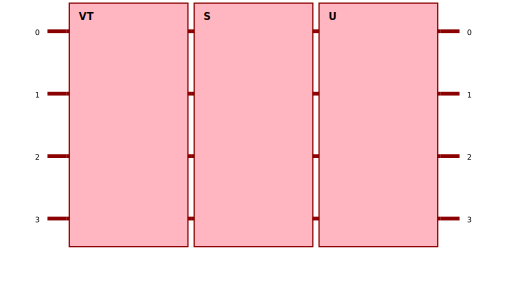

In [11]:
circuit = (pcvl.Circuit(4)
      .add(0, vt_circuit, merge=False)
      .add(0, s_circuit, merge=False)
      .add(0, u_circuit, merge=False)
)

pcvl.pdisplay(circuit, recursive=False)

In [12]:
p = pcvl.Processor("SLOS", circuit)
p.min_detected_photons_filter(1)
p.compute_physical_logical_perf(True)

p.with_input(pcvl.BasicState([1,0,0,1]))
sampler = Sampler(p)
probs = sampler.probs()
print(probs['results'])

{
	|0,1,0,1>: 0.5000000000000007
	|0,1,1,0>: 0.4999999999999994
}
